# SARS-CoV-2 Variants Analysis : Omicron and Delta

## Setup

### Import Libraries

In [ ]:
import numpy as np;
from sklearn.metrics import pairwise_distances;
from sklearn.manifold import MDS;
from matplotlib import pyplot as plt;
from mpl_toolkits.mplot3d import axes3d  
%matplotlib ipympl

### Define functions

In [2]:
def read_fasta(file_path) -> list:
    sequences = []
    cur = ''
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('>'):
                if cur:
                    sequences.append(cur)
                    cur = ''
            else:
                cur += line.strip()
        sequences.append(cur)
    return sequences

def clean_fasta(sequences) -> list:
    for i in range(len(sequences)):
        sequences[i] = sequences[i].upper()
        sequences[i] = \
            ''.join(c for c in sequences[i] if c in {'A','C','G','T'})
    return sequences

def write_fastas(sequences, variant, directory, header=''):
    path_to_dir = f'./{directory}/{variant}'
    for i in range(len(sequences)):
        with open(f'{path_to_dir}/{variant}_{i+1}.fasta', 'w') as f:
            f.write(f'>{header}\n')
            for j in range(0, len(sequences[i]), 60):
                f.write(f'{sequences[i][j:j+60]}\n')
              

def read_sequence(file_path) -> str:
    return read_fasta(file_path)[0]

def cgr(seq, order, k):
    ln = len(seq)
    pw = 2**k
    out = [[0 for i in range(pw)] for j in range(pw)]
    x = 2**(k-1)
    y = 2**(k-1)
    for i in range(0,ln):
        x=x//2
        y=y//2
        if(seq[i] == order[2] or seq[i] == order[3]):
            x = x + (2**(k-1))
        if(seq[i] == order[0] or seq[i] == order[3]):
            y = y + (2**(k-1))
        if(i>=k-1):
            out[y][x] = out[y][x]+1
    return np.array(out)

def perform_mds(diatances_matrix, n=3, random_state=99):
    mds = MDS(n_components=n, dissimilarity='precomputed', random_state=random_state)
    embeddings = mds.fit_transform(diatances_matrix)
    return embeddings

## Data Collection and Preprocessing

In [3]:
directory = "./SARS_CoV_2_Variants"
omicron_file = "omicron.fasta"
delta_file = "delta.fasta"
sequences_delta = clean_fasta(read_fasta(delta_file))
sequences_omicron = clean_fasta(read_fasta(omicron_file))
"""
write_fastas(sequences_omicron, 'Omicron', directory)
write_fastas(sequences_delta, 'Delta', directory)
""";

## Computing CGRs - Chaos Game Representations

In [4]:
cgrs = {'Omicron':[],
        'Delta':[]}
for i in range(len(sequences_delta)):
    sequence = read_sequence(f'{directory}/Delta/Delta_{i+1}.fasta')
    cgrs['Delta'].append(cgr(sequence, 'ACGT', 7).flatten())
for i in range(len(sequences_omicron)):
    sequence = read_sequence(f'{directory}/Omicron/Omicron_{i+1}.fasta')
    cgrs['Omicron'].append(cgr(sequence, 'ACGT', 7).flatten())

## Computing Pairwise Distances

In [5]:
combined_arrays = np.concatenate([cgrs['Delta'], cgrs['Omicron']])
D = pairwise_distances(combined_arrays, metric='manhattan')

In [6]:
D.shape[0] == len(sequences_delta) + len(sequences_omicron)

True

#### Diagonal D(a,a) = 0 check

In [7]:
np.all(np.diag(D) == 0)

True

#### Symmetry D(a,b) = D(b,a) check

In [8]:
np.all(D == D.T)

True

## MDS - Multidimensional Scaling

In [ ]:
reduced = perform_mds(D, 3)
embeddings = {'Delta':[reduced[:len(sequences_delta), _] for _ in range(len(reduced.T))],
              'Omicron':[reduced[len(sequences_delta):, _] for _ in range(len(reduced.T))]}

## Visualization 

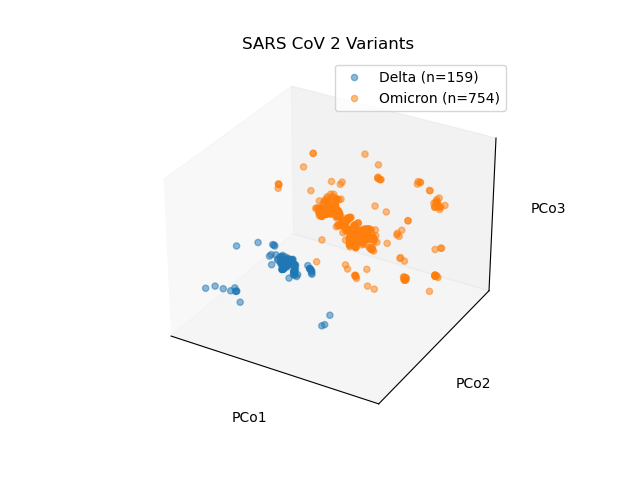

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings['Delta'][0], embeddings['Delta'][1],embeddings['Delta'][2],alpha=0.5, label=f"Delta (n={len(embeddings['Delta'][0])})")
ax.scatter(embeddings['Omicron'][0],embeddings['Omicron'][1],embeddings['Omicron'][2],alpha=0.5, label=f"Omicron (n={len(embeddings['Omicron'][0])})")
ax.set_xlabel('PCo1')
ax.set_ylabel('PCo2')
ax.set_zlabel('PCo3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_title('SARS CoV 2 Variants')
ax.legend()
plt.show()